# 데이터 불러오기

In [5]:
import pandas as pd
import os

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', None)

PATH = './data/서울시 상권분석서비스(오탈자 수정)/'

file_list= os.listdir(PATH)
csv_list = list()

for file in file_list:
    if file.split(".")[-1] == 'csv':
        csv_list.append(file)
data = ['rent','small_rent','big_rent','living_popul','indicator','resident_popul', 'income','apartment', 'area', 'store', 'working_popul', 'facilitie', 'estimated_sales']

for name, file in zip(data, csv_list):
    if name == 'rent':
        globals()[name] = pd.read_csv(PATH + file, names = ['기준년코드', '기준분기코드', '행정동코드', '행정동코드명', '임대시세층구분코드', '임대시세층구분명', '보증금평균','월임대료평균','환산임대료평균','임대건수'],encoding = "ansi")
    else:
        globals()[name] = pd.read_csv(PATH + file, encoding = "ansi")

store = store.drop("Unnamed: 0", axis = 1)
estimated_sales = estimated_sales.drop("Unnamed: 0", axis = 1)

# 데이터 전처리

## 시점 통일

In [6]:
years = [20223, 20224, 20231, 20232]

living_popul = living_popul[living_popul['기준_년분기_코드'].isin(years)]
resident_popul = resident_popul[resident_popul['기준_년분기_코드'].isin(years)]
store = store[store['기준_년분기_코드'].isin(years)]
working_popul = working_popul[working_popul['기준_년분기_코드'].isin(years)]
facilitie = facilitie[facilitie['기준_년분기_코드'].isin(years)]
estimated_sales = estimated_sales[estimated_sales['기준_년분기_코드'].isin(years)]

## 관광특구 삭제

In [7]:
living_popul = living_popul[living_popul['상권_구분_코드_명']!='관광특구']
resident_popul = resident_popul[resident_popul['상권_구분_코드_명']!='관광특구']
store = store[store['상권_구분_코드_명']!='관광특구']
working_popul = working_popul[working_popul['상권_구분_코드_명']!='관광특구']
facilitie = facilitie[facilitie['상권_구분_코드_명']!='관광특구']
estimated_sales = estimated_sales[estimated_sales['상권_구분_코드_명']!='관광특구']

## 길단위인구 전처리

### 파생변수 생성
1.시간대_21_06_유동인구_수
  - 21_00시 유동인구의 특징과 00_06시 유동인구의 특징이 비슷하다고 생각하여 합침

2.주중_유동인구_수
  - 월~금 유동인구 수의 합

3.주말_유동인구_수
  - 토,일 유동인구 수의 합

4.30_40, 50_60대 유동인구 수 합

In [8]:
living_popul['시간대_21_06_유동인구_수'] = living_popul['시간대_00_06_유동인구_수'] + living_popul['시간대_21_24_유동인구_수']
living_popul['주중_유동인구_수'] = living_popul['월요일_유동인구_수'] + living_popul['화요일_유동인구_수'] + living_popul['수요일_유동인구_수'] + living_popul['목요일_유동인구_수'] + living_popul['금요일_유동인구_수']
living_popul['주말_유동인구_수'] = living_popul['토요일_유동인구_수'] + living_popul['일요일_유동인구_수']
living_popul['연령대_30_40_유동인구_수'] = living_popul['연령대_30_유동인구_수'] + living_popul['연령대_40_유동인구_수']
living_popul['연령대_50_60_유동인구_수'] = living_popul['연령대_50_유동인구_수'] + living_popul['연령대_60_이상_유동인구_수']

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 월~일 유동인구 수
- 21~06시 유동인구수
- 30~60대 연령

In [9]:
living_popul = living_popul.drop(['상권_구분_코드','상권_코드','월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수', '시간대_00_06_유동인구_수', '시간대_21_24_유동인구_수','연령대_30_유동인구_수','연령대_40_유동인구_수','연령대_50_유동인구_수','연령대_60_이상_유동인구_수'], axis = 1)

### 결측치 확인 및 제거
- 결측치 없음

In [10]:
living_popul.isnull().sum()

기준_년분기_코드           0
상권_구분_코드_명          0
상권_코드_명             0
총_유동인구_수            0
남성_유동인구_수           0
여성_유동인구_수           0
연령대_10_유동인구_수       0
연령대_20_유동인구_수       0
시간대_06_11_유동인구_수    0
시간대_11_14_유동인구_수    0
시간대_14_17_유동인구_수    0
시간대_17_21_유동인구_수    0
시간대_21_06_유동인구_수    0
주중_유동인구_수           0
주말_유동인구_수           0
연령대_30_40_유동인구_수    0
연령대_50_60_유동인구_수    0
dtype: int64

### 이상치 확인 및 제거
- 하위 5% 제거

In [11]:
living_popul.describe()

,기준_년분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
count,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000,6573.000
mean,20227.499,819172.761,390059.275,429113.498,105750.179,146463.772,166764.988,104697.384,105734.445,141765.368,300210.649,590223.923,228948.919,276078.394,290880.488
std,4.032,860738.310,415405.204,448793.459,112986.973,211285.817,172023.931,119372.114,122503.528,158734.038,318552.356,625430.046,240185.552,311897.390,293363.299
min,20223.000,12.000,12.000,0.000,0.000,0.000,4.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.000,221071.000,106737.000,113709.000,25585.000,32148.000,45786.000,28449.000,28568.000,38153.000,75518.000,158928.000,60054.000,74201.000,79250.000
50%,20224.000,566885.000,269133.000,296501.000,71313.000,82738.000,116615.000,71878.000,71921.000,95899.000,205337.000,405241.000,158567.000,184591.000,205254.000
75%,20231.000,1130788.000,534060.000,588669.000,146355.000,182991.000,233054.000,139191.000,139491.000,193507.000,414441.000,822348.000,311102.000,369148.000,409490.000
max,20232.000,7942915.000,4000287.000,4032096.000,829062.000,3487417.000,1529921.000,1429461.000,1491003.000,1793125.000,2942275.000,6236830.000,2124591.000,3433420.000,2463853.000


In [12]:
living_popul['총_유동인구_수'].quantile(0.05)

41037.200000000004

In [13]:
living_popul = living_popul[living_popul['총_유동인구_수']>living_popul['총_유동인구_수'].quantile(0.05)]

In [14]:
living_popul.describe()

,기준_년분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
count,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000,6244.000
mean,20227.500,861007.418,409971.520,451035.914,111144.242,153997.007,175276.202,110032.630,111122.823,149007.149,315568.686,620359.782,240647.721,290180.393,305685.847
std,4.031,863096.762,416810.529,449916.683,113389.502,214149.643,172348.288,120132.091,123359.863,159612.613,319544.916,627396.371,240819.332,313738.696,293625.975
min,20223.000,41072.000,13408.000,18623.000,1160.000,558.000,7115.000,3788.000,3588.000,4534.000,5504.000,28199.000,8959.000,8992.000,8232.000
25%,20223.750,265570.000,127060.000,139001.500,30543.000,37973.750,54613.250,33662.500,34618.750,45653.500,89887.250,190333.250,74086.750,88205.500,96457.750
50%,20227.500,603379.500,289128.000,315265.500,76537.000,89099.000,124512.000,76581.000,77453.500,102923.500,221175.500,437589.000,167723.000,197354.500,221065.000
75%,20231.000,1191739.750,559779.750,621915.750,151699.500,191301.500,241329.250,145259.500,145725.250,200731.750,432292.250,858979.000,328543.500,383017.750,421936.000
max,20232.000,7942915.000,4000287.000,4032096.000,829062.000,3487417.000,1529921.000,1429461.000,1491003.000,1793125.000,2942275.000,6236830.000,2124591.000,3433420.000,2463853.000


### 중복행 확인 및 제거
- 중복행 없음

In [15]:
living_popul[living_popul.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수


### 분기데이터 1년치 데이터로 변환
- 유동인구 -> 4개 분기의 평균

In [16]:
living_popul_year = living_popul.groupby(['상권_구분_코드_명','상권_코드_명'],as_index=False).mean()
living_popul_year = living_popul_year.drop('기준_년분기_코드', axis = 1)

## 상주인구 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 총 상주인구 수
- 남성 상주인구 수
- 여성 상주인구 수
- 연령대 10 ~ 60 이상상주인구 수
- 총 가구 수, 아파트 가구 수, 비아파트 가구수

In [17]:
resident_popul[resident_popul['상권_코드_명']=='개포지하차도 북측']

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_상주인구_수,연령대_40_상주인구_수,연령대_50_상주인구_수,연령대_60_이상_상주인구_수,남성연령대_10_상주인구_수,남성연령대_20_상주인구_수,남성연령대_30_상주인구_수,남성연령대_40_상주인구_수,남성연령대_50_상주인구_수,남성연령대_60_이상_상주인구_수,여성연령대_10_상주인구_수,여성연령대_20_상주인구_수,여성연령대_30_상주인구_수,여성연령대_40_상주인구_수,여성연령대_50_상주인구_수,여성연령대_60_이상_상주인구_수,총_가구_수,아파트_가구_수,비_아파트_가구_수
16007,20223,A,골목상권,3110993,개포지하차도 북측,234,121,113,27,36,39,33,42,57,14,24,25,14,21,23,13,12,14,19,21,34,119,0,119
17640,20224,A,골목상권,3110993,개포지하차도 북측,236,107,129,28,25,45,44,31,63,17,15,19,14,13,29,11,10,26,30,18,34,119,0,119
19249,20231,A,골목상권,3110993,개포지하차도 북측,236,107,129,28,25,45,44,31,63,17,15,19,14,13,29,11,10,26,30,18,34,110,0,110
20878,20232,A,골목상권,3110993,개포지하차도 북측,236,107,129,28,25,45,44,31,63,17,15,19,14,13,29,11,10,26,30,18,34,119,0,119


In [18]:
resident_popul = resident_popul[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','총_상주인구_수','남성_상주인구_수','여성_상주인구_수','연령대_10_상주인구_수','연령대_20_상주인구_수','연령대_30_상주인구_수','연령대_40_상주인구_수','연령대_50_상주인구_수','연령대_60_이상_상주인구_수']]

### 파생변수 생성

In [19]:
resident_popul['상권_구분_코드_명'].unique()

array(['골목상권', '발달상권', '전통시장'], dtype=object)

In [20]:
resident_popul['연령대_30_40_상주인구_수'] = resident_popul['연령대_30_상주인구_수']+resident_popul['연령대_40_상주인구_수']
resident_popul['연령대_50_60_상주인구_수'] = resident_popul['연령대_50_상주인구_수']+resident_popul['연령대_60_이상_상주인구_수']

In [21]:
resident_popul.drop(['연령대_30_상주인구_수','연령대_40_상주인구_수','연령대_50_상주인구_수','연령대_60_이상_상주인구_수'],axis=1,inplace=True)

### 결측치 확인 및 제거
- 결측치 없음

In [22]:
resident_popul.isnull().sum()

기준_년분기_코드           0
상권_구분_코드_명          0
상권_코드_명             0
총_상주인구_수            0
남성_상주인구_수           0
여성_상주인구_수           0
연령대_10_상주인구_수       0
연령대_20_상주인구_수       0
연령대_30_40_상주인구_수    0
연령대_50_60_상주인구_수    0
dtype: int64

### 이상치 확인 및 제거
- 이상치가 없다고 판단됨

In [23]:
resident_popul.describe()

,기준_년분기_코드,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_40_상주인구_수,연령대_50_60_상주인구_수
count,6488.000,6488.000,6488.000,6488.000,6488.000,6488.000,6488.000,6488.000
mean,20227.495,2359.471,1165.882,1193.589,230.282,300.194,789.012,1039.983
std,4.032,2348.110,1159.129,1194.338,262.202,339.598,833.507,1031.546
min,20223.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.000,657.000,326.750,330.750,53.000,70.000,207.000,280.000
50%,20224.000,1614.000,809.000,817.000,147.000,195.000,528.000,720.000
75%,20231.000,3305.000,1639.000,1677.000,318.000,413.250,1083.000,1464.250
max,20232.000,21341.000,10459.000,10882.000,3078.000,4457.000,7626.000,8342.000


In [24]:
resident_popul[resident_popul['총_상주인구_수']>15000]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_40_상주인구_수,연령대_50_60_상주인구_수
15673,20223,골목상권,화곡역 4번,18476,8997,9479,2694,2923,6249,6610
17307,20224,골목상권,화곡역 4번,21341,10459,10882,3078,2295,7626,8342
18919,20231,골목상권,화곡역 4번,21341,10459,10882,3078,2295,7626,8342
20544,20232,골목상권,화곡역 4번,21341,10459,10882,3078,2295,7626,8342


In [25]:
outlier_list = list(resident_popul[resident_popul['총_상주인구_수']<10].상권_코드_명.unique())
for i in outlier_list:
    print(resident_popul[resident_popul['상권_코드_명']==i])

       기준_년분기_코드 상권_구분_코드_명    상권_코드_명  총_상주인구_수  남성_상주인구_수  여성_상주인구_수  \
15122      20223       골목상권  성동구립금호도서관         3          1          2   
16756      20224       골목상권  성동구립금호도서관         3          1          2   
18369      20231       골목상권  성동구립금호도서관         3          1          2   
19994      20232       골목상권  성동구립금호도서관         3          1          2   

       연령대_10_상주인구_수  연령대_20_상주인구_수  연령대_30_40_상주인구_수  연령대_50_60_상주인구_수  
15122              0              0                 1                 2  
16756              0              0                 1                 2  
18369              0              0                 1                 2  
19994              0              0                 1                 2  
       기준_년분기_코드 상권_구분_코드_명 상권_코드_명  총_상주인구_수  남성_상주인구_수  여성_상주인구_수  \
15807      20223       골목상권  대림썬프라자         1          1          0   
17441      20224       골목상권  대림썬프라자         9          5          4   
19052      20231       골목상권  대림썬프라자         9 

### 중복행 확인 및 제거
- 중복행 없음

In [26]:
resident_popul[resident_popul.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_40_상주인구_수,연령대_50_60_상주인구_수


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 상주인구만 추출

In [27]:
resident_popul_year = resident_popul[resident_popul['기준_년분기_코드'] == 20232]
resident_popul_year = resident_popul_year.drop(['기준_년분기_코드'],axis=1)

## 점포 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 서비스_업종_코드

In [28]:
store.drop(['상권_구분_코드','상권_코드','서비스_업종_코드'],axis=1,inplace=True)

### 파생변수 생성

In [29]:
# food = ['호프-간이주점','중식음식점','패스트푸드점','분식전문점','치킨전문점','일식음식점','양식음식점','한식음식점','제과점','커피-음료']
# edu_service = ['예술학원','컴퓨터학원','일반교습학원','외국어학원','스포츠 강습','스포츠클럽','골프연습장']
# accommodation = ['여관','고시원']
# repair_service = ['자동차수리','가전제품수리','미용실','세탁소','피부관리실','자동차미용','PC방','인테리어','네일숍','노래방','당구장']
# retail = ['편의점','슈퍼마켓','육류판매','수산물판매','일반의류','화장품','컴퓨터및주변장치판매','가구','서적','의약품','조명용품',
#          '미곡판매','화초','문구','청과상','안경','의료기기','운동/경기용품','철물점','시계및귀금속','가방','완구','자전거 및 기타운송장비',
#           '애완동물','섬유제품','신발','가전제품','핸드폰','전자상거래업', '반찬가게']
# medical = ['일반의원','치과의원','한의원']
# real_estate = ['부동산중개업']

In [30]:
# def industry_categoty(df):
#     if df['서비스_업종_코드_명'] in food:
#         return '음식점업'
#     elif df['서비스_업종_코드_명'] in edu_service:
#         return '교육 서비스업'
#     elif df['서비스_업종_코드_명'] in accommodation:
#         return '숙박업'
#     elif df['서비스_업종_코드_명'] in repair_service:
#         return '수리 및 기타 서비스업'
#     elif df['서비스_업종_코드_명'] in retail:
#         return '도매 및 소매업'
#     elif df['서비스_업종_코드_명'] in medical:
#         return '보건업 및 의료 서비스업'
#     elif df['서비스_업종_코드_명'] in real_estate:
#         return '부동산업'

In [31]:
# df['서비스업종_대분류'] = df.apply(industry_categoty, axis=1)

In [32]:
# df['서비스업종_대분류'].unique()

In [33]:
# df[df['서비스업종_대분류'].isna()]['서비스_업종_코드_명'].unique()

In [34]:
# df.head()

### 중복행 확인 및 제거
- 중복행 없음

In [35]:
store[store.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수


### 결측치 확인 및 제거
- 결측치 없음

In [36]:
store.isnull().sum()

기준_년분기_코드      0
상권_구분_코드_명     0
상권_코드_명        0
서비스_업종_코드_명    0
점포_수           0
유사_업종_점포_수     0
개업_율           0
개업_점포_수        0
폐업_률           0
폐업_점포_수        0
프랜차이즈_점포_수     0
dtype: int64

### 이상치 확인 및 제거
- 점포수 -> 8500개? 이상치 인듯?

In [37]:
store.describe()

,기준_년분기_코드,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수
count,302726.000,302726.000,302726.000,302726.000,302726.000,302726.000,302726.000,302726.000
mean,20227.497,5.692,6.126,2.296,0.134,2.482,0.171,0.434
std,4.031,25.823,26.281,10.924,0.584,11.827,0.784,2.047
min,20223.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,20224.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000
75%,20231.000,4.000,5.000,0.000,0.000,0.000,0.000,0.000
max,20232.000,2190.000,2191.000,200.000,28.000,400.000,71.000,123.000


In [38]:
store[store['점포_수']>1000]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수
1056166,20223,발달상권,구로역,조명용품,2190,2191,0,3,1,11,1
1059879,20223,발달상권,가락시장,청과상,1655,1655,0,5,1,9,0
1070476,20223,발달상권,가산디지털단지,전자상거래업,1207,1211,0,2,3,41,4
1077493,20223,발달상권,용산전자상가(용산역),컴퓨터및주변장치판매,1826,1828,0,8,2,32,2
1088295,20223,발달상권,신당역,일반의류,1749,1754,0,1,4,62,5
1101418,20223,전통시장,"평화시장(통일상가, 동화상가)",일반의류,1278,1282,1,11,3,42,4
1118140,20223,전통시장,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",일반의류,1908,1909,0,4,4,68,1
1120537,20223,발달상권,교대역(법원.검찰청),변호사사무소,1323,1324,1,15,3,34,1
1121756,20223,발달상권,종로3가역,시계및귀금속,1451,1452,1,11,1,8,1
1125326,20223,전통시장,청평화시장,일반의류,2138,2142,0,0,3,59,4


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [39]:
store_year = store[store['기준_년분기_코드'] == 20232]
store_year = store_year.drop(columns = ['기준_년분기_코드'])

## 직장인구 전처리

### 필요한 컬럼만 추출
- 기준_년분기_코드
- 상권_구분_코드_명
- 상권_코드_명
- 총_직장_인구_수

In [40]:
working_popul = working_popul[['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '총_직장_인구_수']]


### 결측치 확인 및 제거
- 결측치 없음

In [41]:
working_popul.isnull().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
총_직장_인구_수     0
dtype: int64

### 이상치 확인 및 제거
- 이상치 없음

In [42]:
working_popul.describe()

,기준_년분기_코드,총_직장_인구_수
count,6468.000,6468.000
mean,20227.500,1660.112
std,4.031,5611.955
min,20223.000,1.000
25%,20223.750,105.000
50%,20227.500,315.000
75%,20231.250,876.000
max,20232.000,81127.000


In [43]:
working_popul[working_popul['총_직장_인구_수']>60000]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_직장_인구_수
7062,20223,발달상권,포스코사거리,61667
8043,20223,발달상권,가산디지털단지,81127
8083,20223,발달상권,강남역,72613
8259,20223,발달상권,여의도역(여의도),69255
8685,20224,발달상권,포스코사거리,61667
9665,20224,발달상권,가산디지털단지,81127
9706,20224,발달상권,강남역,72613
9882,20224,발달상권,여의도역(여의도),69255
10293,20231,발달상권,포스코사거리,61667
11271,20231,발달상권,가산디지털단지,81127


### 중복행 확인 및 제거
- 중복행 없음

In [44]:
working_popul[working_popul.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_직장_인구_수


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [45]:
working_popul_year = working_popul[working_popul['기준_년분기_코드'] == 20232]
working_popul_year = working_popul_year.drop(['기준_년분기_코드'],axis=1)

## 집객시설 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 집객시설_수

In [46]:
facilitie.drop(['상권_구분_코드','상권_코드','집객시설_수','철도_역_수'],axis=1,inplace=True)

### 파생변수 생성

In [47]:
facilitie['초중고_수'] = facilitie['초등학교_수']+facilitie['중학교_수']+facilitie['고등학교_수']
facilitie.drop(['초등학교_수','중학교_수','고등학교_수'],axis=1,inplace=True)

### 결측치 확인 및 제거
- 결측치 -> 0으로 처리

In [48]:
facilitie.isnull().sum()

기준_년분기_코드        0
상권_구분_코드_명       0
상권_코드_명          0
관공서_수         3792
은행_수          4364
종합병원_수        6200
일반_병원_수       5764
약국_수          2276
유치원_수         5684
대학교_수         5956
백화점_수         6252
슈퍼마켓_수        5884
극장_수          5972
숙박_시설_수       5720
공항_수          6284
버스_터미널_수      6280
지하철_역_수       5528
버스_정거장_수      1232
초중고_수         6288
dtype: int64

In [49]:
facilitie.shape

(6288, 19)

In [50]:
facilitie = facilitie.fillna(0)
facilitie.isnull().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
관공서_수         0
은행_수          0
종합병원_수        0
일반_병원_수       0
약국_수          0
유치원_수         0
대학교_수         0
백화점_수         0
슈퍼마켓_수        0
극장_수          0
숙박_시설_수       0
공항_수          0
버스_터미널_수      0
지하철_역_수       0
버스_정거장_수      0
초중고_수         0
dtype: int64

### 이상치 확인 및 제거
- 은행 52개 버스정거장수 85 집객 시설 수 594개 이상한데

In [51]:
facilitie.describe()

,기준_년분기_코드,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수
count,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000,6288.000
mean,20227.500,0.678,0.947,0.015,0.107,2.299,0.112,0.087,0.006,0.094,0.066,0.198,0.003,0.001,0.167,3.828,0.000
std,4.031,1.111,2.591,0.125,0.396,3.812,0.386,0.466,0.087,0.467,0.321,0.933,0.101,0.036,0.507,4.789,0.000
min,20223.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
50%,20227.500,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000
75%,20231.250,1.000,1.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000
max,20232.000,10.000,41.000,2.000,4.000,52.000,6.000,7.000,2.000,8.000,4.000,18.000,4.000,1.000,5.000,85.000,0.000


In [52]:
facilitie[facilitie['약국_수']==52]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수
2544,20232,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000
2545,20231,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000
14631,20224,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000
14632,20223,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000


In [53]:
facilitie[facilitie['버스_정거장_수']>80]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수
2386,20232,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000
2387,20231,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000
13920,20224,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000
13921,20223,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000


In [54]:
area[area['상권_코드_명']=='가산디지털단지']

,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,자치구_코드,자치구_코드_명,행정동_코드,행정동_코드_명,영역_면적
1235,D,발달상권,3120131,가산디지털단지,189641,441969,11545,금천구,11545510,가산동,1713620


In [55]:
area[area['상권_코드_명']=='명동 남대문 북창동 다동 무교동 관광특구']

,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,자치구_코드,자치구_코드_명,행정동_코드,행정동_코드_명,영역_면적
1645,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,198397,451614,11140,중구,11140520,소공동,983618


In [56]:
area.describe()

,상권_코드,엑스좌표_값,와이좌표_값,자치구_코드,행정동_코드,영역_면적
count,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000
mean,3115221.905,198981.845,449875.452,11426.218,11426858.585,99927.952
std,10321.659,7280.721,5590.503,190.534,190548.801,118818.943
min,3001491.000,182509.000,437249.000,11110.000,11110515.000,1854.000
25%,3110407.250,192815.250,445178.500,11260.000,11260575.000,35330.000
50%,3110819.500,200096.000,449849.500,11440.000,11440590.000,71927.500
75%,3120141.750,204366.250,453563.500,11590.000,11590560.000,128147.250
max,3130327.000,215352.000,465573.000,11740.000,11740700.000,2462734.000


### 중복행 확인 및 제거
- 중복행 없음


In [57]:
facilitie[facilitie.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [58]:
facilitie_year = facilitie[facilitie['기준_년분기_코드'] == 20232]
facilitie_year = facilitie_year.drop(['기준_년분기_코드'],axis=1)

## 추정매출 전처리

### 파생변수 생성
1.시간대_21_06_매출_건수, 시간대_21_06_매출_금액
- 21_00시 유동인구의 특징과 00_06시 유동인구의 특징이 비슷하다고 판단함

In [59]:
estimated_sales['시간대_21~06_매출_금액'] = estimated_sales['시간대_00~06_매출_금액'] + estimated_sales['시간대_21~24_매출_금액']
estimated_sales['시간대_21~06_매출_건수'] = estimated_sales['시간대_건수~06_매출_건수'] + estimated_sales['시간대_건수~24_매출_건수']
estimated_sales['연령대_30_40_매출_금액'] = estimated_sales['연령대_30_매출_금액'] + estimated_sales['연령대_40_매출_금액']
estimated_sales['연령대_50_60_매출_금액'] = estimated_sales['연령대_50_매출_금액'] + estimated_sales['연령대_60_이상_매출_금액']
estimated_sales['연령대_30_40_매출_건수'] = estimated_sales['연령대_30_매출_건수'] + estimated_sales['연령대_40_매출_건수']
estimated_sales['연령대_50_60_매출_건수'] = estimated_sales['연령대_50_매출_건수'] + estimated_sales['연령대_60_이상_매출_건수']

### 불필요한 feature제거
- 상권_구분_코드- 
상권_코
- 서비스_업종_코드
- 21~06 매출금액, 매출건수
- 월~일 매출금액, 매출건수드

In [60]:
estimated_sales = estimated_sales.drop(columns = ['상권_구분_코드', '상권_코드', '서비스_업종_코드'],
                                       axis = 1)
estimated_sales = estimated_sales.drop(columns = ['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액',
                                                  '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수', '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수'],
                                       axis = 1)
estimated_sales = estimated_sales.drop(columns = ['시간대_00~06_매출_금액', '시간대_21~24_매출_금액', '시간대_건수~06_매출_건수', '시간대_건수~24_매출_건수',
                                                 '연령대_30_매출_금액','연령대_40_매출_금액','연령대_50_매출_금액','연령대_60_이상_매출_금액',
                                                 '연령대_30_매출_건수','연령대_40_매출_건수','연령대_50_매출_건수','연령대_60_이상_매출_건수'],
                                       axis = 1)

### 결측치 확인 및 제거
- 결측치 어떻게 처리하지

In [61]:
estimated_sales.isnull().sum()

기준_년분기_코드          0
상권_구분_코드_명         0
상권_코드_명            0
서비스_업종_코드_명        0
당월_매출_금액           0
당월_매출_건수           0
주중_매출_금액           0
주말_매출_금액           0
시간대_06~11_매출_금액    0
시간대_11~14_매출_금액    0
시간대_14~17_매출_금액    0
시간대_17~21_매출_금액    0
남성_매출_금액           0
여성_매출_금액           0
연령대_10_매출_금액       0
연령대_20_매출_금액       0
주중_매출_건수           0
주말_매출_건수           0
시간대_건수~11_매출_건수    0
시간대_건수~14_매출_건수    0
시간대_건수~17_매출_건수    0
시간대_건수~21_매출_건수    0
남성_매출_건수           0
여성_매출_건수           0
연령대_10_매출_건수       0
연령대_20_매출_건수       0
시간대_21~06_매출_금액    0
시간대_21~06_매출_건수    0
연령대_30_40_매출_금액    0
연령대_50_60_매출_금액    0
연령대_30_40_매출_건수    0
연령대_50_60_매출_건수    0
dtype: int64

### 이상치 확인 및 제거
- 당원매출금액 천억 이상치인듯

In [62]:
estimated_sales.describe()

,기준_년분기_코드,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수
count,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000,83142.000
mean,20227.506,1057530630.270,37378.921,800998140.292,256532440.674,112812620.583,270639855.442,263642589.533,289522260.989,482553877.888,454435667.863,5388979.464,125426918.046,28218.137,9160.785,5231.569,9703.087,7869.907,9959.027,18572.037,17223.529,559.116,7452.457,120913224.832,4615.330,406737845.752,399433563.022,15695.358,12088.637
std,4.031,9247199458.539,158825.344,6375468667.307,3472245561.224,1170991051.609,2448384035.026,3090139741.176,2707954382.716,4423202984.139,3474196467.177,29279037.589,839832564.084,111071.872,54745.766,27854.478,43249.044,41592.007,44177.137,80157.083,76442.682,3521.526,39113.158,983837619.257,22925.971,3379770530.233,3754679997.219,67955.953,60479.077
min,20223.000,12.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20224.000,48000000.000,859.000,35761235.750,7349956.500,135702.250,5399863.500,7746083.500,11697304.250,19337881.500,17810972.500,0.000,1333739.750,646.000,152.000,6.000,107.000,171.000,224.000,386.000,337.000,0.000,42.000,0.000,0.000,15640213.000,15286881.750,321.000,294.000
50%,20231.000,184854645.500,4585.000,138333420.000,37661145.000,6136944.500,34222861.000,35608985.500,49693963.000,82942230.000,74623180.000,160833.000,12158489.500,3400.000,1018.000,165.000,967.000,966.000,1287.000,2253.000,1937.500,12.000,438.000,3981946.500,76.000,68591283.500,62915461.000,1756.000,1620.000
75%,20232.000,670335090.750,24990.750,508560976.750,146729693.250,47316932.250,149821606.500,139409257.750,182213664.750,307190696.500,282747046.500,2212020.500,62126169.750,18704.250,5709.750,1965.000,6277.000,5095.000,6880.000,11848.000,11338.000,170.000,3233.750,50244980.000,1468.000,254483601.000,235029535.000,9660.000,8417.250
max,20232.000,995677000000.000,12090273.000,669799000000.000,485357000000.000,107916000000.000,242249000000.000,326543000000.000,386343000000.000,537243000000.000,304162000000.000,1549259735.000,90669553834.000,5827863.000,6262410.000,1474148.000,2611826.000,3245770.000,4287338.000,6708993.000,4615812.000,329040.000,3087414.000,126314287024.000,1514884.000,354347000000.000,411544000000.000,4519958.000,5329793.000


In [63]:
estimated_sales = estimated_sales[estimated_sales['당월_매출_금액'] > estimated_sales['당월_매출_금액'].quantile(0.05)]

In [64]:
# estimated_sales = estimated_sales[estimated_sales['주중_매출_금액']!=0]

In [65]:
estimated_sales.describe()

,기준_년분기_코드,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수
count,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000,78928.000
mean,20227.510,1113841172.476,39367.187,843647186.297,270193934.243,118824937.633,285055108.985,277671702.287,304933139.815,508253258.229,478617914.935,5675925.150,132108337.805,29719.126,9648.061,5510.230,10219.217,8287.938,10488.641,19559.983,18139.572,588.867,7849.136,127356200.655,4861.162,428396536.976,420688014.715,16530.533,12731.024
std,4.031,9487552189.528,162770.715,6540709409.978,3563217105.487,1201548075.888,2512079201.811,3170947822.321,2778461615.876,4538312010.823,3564117844.219,30023444.451,861449755.553,113803.301,56146.524,28561.591,44329.342,42647.484,45280.063,82151.965,78351.239,3611.892,40105.023,1009354545.678,23504.676,3467487837.074,3852453280.925,69647.754,62006.985
min,20223.000,6000485.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20224.000,60733851.750,1138.000,44920920.000,10035309.500,387665.000,7683850.250,10240340.000,15116632.250,25175694.250,23129796.500,0.000,2107129.000,848.000,216.000,12.000,156.000,230.000,302.000,525.000,450.000,0.000,64.000,0.000,0.000,20518821.750,19711571.750,427.000,399.000
50%,20231.000,210227998.000,5349.000,157415394.500,43038376.000,7680995.500,39874696.500,40692349.000,56563574.000,94229444.500,85066347.000,233841.000,14304849.500,3980.500,1201.500,211.000,1175.000,1134.000,1506.000,2649.000,2271.000,16.000,536.000,5424718.500,105.000,78128574.000,71504765.000,2064.000,1885.000
75%,20232.000,718642257.250,27495.500,545957879.750,157386783.250,52294646.000,161737705.250,149911292.500,195812427.750,330805947.500,305053756.500,2469580.000,67885500.500,20632.000,6286.000,2239.250,6920.500,5602.250,7572.000,13098.750,12399.250,193.000,3605.250,56105212.250,1685.250,273401507.000,254380103.500,10769.000,9305.250
max,20232.000,995677000000.000,12090273.000,669799000000.000,485357000000.000,107916000000.000,242249000000.000,326543000000.000,386343000000.000,537243000000.000,304162000000.000,1549259735.000,90669553834.000,5827863.000,6262410.000,1474148.000,2611826.000,3245770.000,4287338.000,6708993.000,4615812.000,329040.000,3087414.000,126314287024.000,1514884.000,354347000000.000,411544000000.000,4519958.000,5329793.000


In [66]:
estimated_sales['당월_개인_매출_금액'] = estimated_sales['남성_매출_금액'] + estimated_sales['여성_매출_금액']
estimated_sales['당월_법인_매출_금액'] =  estimated_sales['당월_매출_금액'] - estimated_sales['당월_개인_매출_금액']

In [67]:
estimated_sales[estimated_sales['당월_법인_매출_금액'] < 0]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수,당월_개인_매출_금액,당월_법인_매출_금액
123702,20223,골목상권,수락산디자인거리,미용실,128155270.000,3576,77245305.000,50909965.000,4474130.000,39437551.000,41771165.000,42472424.000,46376063.000,81779208.000,2583063,19338039,2202,1374,239,1098,1175,1064,1852,1723,70,595,0.000,0,62900581.000,43333588.000,1803,1107,128155271.000,-1.000
124584,20223,골목상권,남가좌동현대아파트,예술학원,82300920.000,562,74595784.000,7705136.000,2417887.000,15628905.000,38749921.000,24317797.000,24242787.000,58058134.000,0,739884,502,60,27,113,261,154,201,362,0,5,1186410.000,7,79672129.000,1888907.000,541,16,82300921.000,-1.000
126952,20223,골목상권,독산2동주민센터,예술학원,16296020.000,142,16296020.000,0.000,0.000,2562074.000,9816950.000,1662610.000,5337505.000,10958516.000,0,0,142,0,0,22,78,28,59,82,0,0,2254386.000,14,15649030.000,646991.000,137,4,16296021.000,-1.000
131445,20223,발달상권,금호역,일반의류,110771775.000,1445,82737977.000,28033798.000,1360644.000,33070520.000,22738223.000,44340462.000,19589891.000,91181885.000,0,4969090,1113,332,41,428,336,631,202,1244,0,33,9261926.000,9,32852399.000,72950287.000,421,992,110771776.000,-1.000
134214,20223,발달상권,영중로,스포츠클럽,11692459.000,13,11692459.000,0.000,0.000,0.000,0.000,945714.000,5158438.000,6534022.000,0,5588308,13,0,0,0,0,4,4,8,0,4,10746745.000,9,6104152.000,0.000,8,0,11692460.000,-1.000
134285,20223,발달상권,보라매역,스포츠 강습,68614852.000,249,49224484.000,19390368.000,3847017.000,14516035.000,14529714.000,8791609.000,37723373.000,30891480.000,0,1313616,184,65,9,50,72,44,118,132,0,5,26930477.000,74,57150765.000,10150472.000,206,39,68614853.000,-1.000
140165,20223,전통시장,신원시장,네일숍,31342017.000,62,29170078.000,2171939.000,0.000,682610.000,6784651.000,23548290.000,12179733.000,19162285.000,296787,4281193,40,22,0,10,19,28,8,55,5,20,326466.000,5,7038566.000,19725471.000,16,21,31342018.000,-1.000
140497,20223,전통시장,문정동 로데오거리 상점가(문정동 로데오거리),스포츠 강습,68187459.000,329,58420474.000,9766985.000,0.000,14753723.000,21473743.000,29377934.000,37350033.000,30837427.000,0,8386110,257,72,32,64,102,127,200,131,0,19,2582059.000,4,54028154.000,5773196.000,280,32,68187460.000,-1.000
143091,20224,골목상권,상봉역 4번,스포츠 강습,13335651.000,37,13335651.000,0.000,0.000,0.000,0.000,5165217.000,7888696.000,5446956.000,140870,3052174,37,0,0,0,0,23,19,20,5,9,8170434.000,14,5916522.000,4226086.000,15,10,13335652.000,-1.000
146497,20224,골목상권,신한은행 신월동지점,스포츠 강습,54902259.000,168,54902259.000,0.000,0.000,1821288.000,4258438.000,38723951.000,35280444.000,19621816.000,0,3035480,168,0,0,4,12,116,126,41,0,4,10098582.000,36,32345687.000,19521093.000,107,56,54902260.000,-1.000


In [68]:
def sales_tran(df):
    if df['당월_법인_매출_금액'] < 0:
        return df['당월_매출_금액'] - df['당월_법인_매출_금액']
    else :
        return df['당월_매출_금액']

In [69]:
estimated_sales['당월_매출_금액'] = estimated_sales.apply(lambda x : sales_tran(x) , axis=1)

In [70]:
estimated_sales[estimated_sales['당월_법인_매출_금액'] < 0]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수,당월_개인_매출_금액,당월_법인_매출_금액
123702,20223,골목상권,수락산디자인거리,미용실,128155271.000,3576,77245305.000,50909965.000,4474130.000,39437551.000,41771165.000,42472424.000,46376063.000,81779208.000,2583063,19338039,2202,1374,239,1098,1175,1064,1852,1723,70,595,0.000,0,62900581.000,43333588.000,1803,1107,128155271.000,-1.000
124584,20223,골목상권,남가좌동현대아파트,예술학원,82300921.000,562,74595784.000,7705136.000,2417887.000,15628905.000,38749921.000,24317797.000,24242787.000,58058134.000,0,739884,502,60,27,113,261,154,201,362,0,5,1186410.000,7,79672129.000,1888907.000,541,16,82300921.000,-1.000
126952,20223,골목상권,독산2동주민센터,예술학원,16296021.000,142,16296020.000,0.000,0.000,2562074.000,9816950.000,1662610.000,5337505.000,10958516.000,0,0,142,0,0,22,78,28,59,82,0,0,2254386.000,14,15649030.000,646991.000,137,4,16296021.000,-1.000
131445,20223,발달상권,금호역,일반의류,110771776.000,1445,82737977.000,28033798.000,1360644.000,33070520.000,22738223.000,44340462.000,19589891.000,91181885.000,0,4969090,1113,332,41,428,336,631,202,1244,0,33,9261926.000,9,32852399.000,72950287.000,421,992,110771776.000,-1.000
134214,20223,발달상권,영중로,스포츠클럽,11692460.000,13,11692459.000,0.000,0.000,0.000,0.000,945714.000,5158438.000,6534022.000,0,5588308,13,0,0,0,0,4,4,8,0,4,10746745.000,9,6104152.000,0.000,8,0,11692460.000,-1.000
134285,20223,발달상권,보라매역,스포츠 강습,68614853.000,249,49224484.000,19390368.000,3847017.000,14516035.000,14529714.000,8791609.000,37723373.000,30891480.000,0,1313616,184,65,9,50,72,44,118,132,0,5,26930477.000,74,57150765.000,10150472.000,206,39,68614853.000,-1.000
140165,20223,전통시장,신원시장,네일숍,31342018.000,62,29170078.000,2171939.000,0.000,682610.000,6784651.000,23548290.000,12179733.000,19162285.000,296787,4281193,40,22,0,10,19,28,8,55,5,20,326466.000,5,7038566.000,19725471.000,16,21,31342018.000,-1.000
140497,20223,전통시장,문정동 로데오거리 상점가(문정동 로데오거리),스포츠 강습,68187460.000,329,58420474.000,9766985.000,0.000,14753723.000,21473743.000,29377934.000,37350033.000,30837427.000,0,8386110,257,72,32,64,102,127,200,131,0,19,2582059.000,4,54028154.000,5773196.000,280,32,68187460.000,-1.000
143091,20224,골목상권,상봉역 4번,스포츠 강습,13335652.000,37,13335651.000,0.000,0.000,0.000,0.000,5165217.000,7888696.000,5446956.000,140870,3052174,37,0,0,0,0,23,19,20,5,9,8170434.000,14,5916522.000,4226086.000,15,10,13335652.000,-1.000
146497,20224,골목상권,신한은행 신월동지점,스포츠 강습,54902260.000,168,54902259.000,0.000,0.000,1821288.000,4258438.000,38723951.000,35280444.000,19621816.000,0,3035480,168,0,0,4,12,116,126,41,0,4,10098582.000,36,32345687.000,19521093.000,107,56,54902260.000,-1.000


In [71]:
estimated_sales.loc[estimated_sales['당월_법인_매출_금액']<0, '당월_법인_매출_금액'] = 0

In [72]:
estimated_sales[estimated_sales['당월_법인_매출_금액']<0]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수,당월_개인_매출_금액,당월_법인_매출_금액


### 중복행 확인 및 제거
- 중복행 없음

In [73]:
estimated_sales[estimated_sales.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수,당월_개인_매출_금액,당월_법인_매출_금액


### feature순서 재배치

In [74]:
# cols_1 = ['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명']

# cols_2 = ['당월_매출_금액', '주중_매출_금액', '주말_매출_금액',
#          '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~06_매출_금액',
#          '남성_매출_금액', '여성_매출_금액', 
#          '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액']

# cols_3 = ['당월_매출_건수', '주중_매출_건수', '주말_매출_건수',
#          '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수', '시간대_건수~21_매출_건수', '시간대_21~06_매출_건수',
#          '남성_매출_건수', '여성_매출_건수',
#          '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수']

# cols_4 = ['당월_건당_매출_금액', '주중_건당_매출_금액', '주말_건당_매출_금액',
#          '시간대_06~11_건당_매출_금액', '시간대_11~14_건당_매출_금액', '시간대_14~17_건당_매출_금액', '시간대_17~21_건당_매출_금액', '시간대_21~06_건당_매출_금액',
#          '남성_건당_매출_금액', '여성_건당_매출_금액',
#          '연령대_10_건당_매출_금액', '연령대_20_건당_매출_금액', '연령대_30_건당_매출_금액', '연령대_40_건당_매출_금액', '연령대_50_건당_매출_금액', '연령대_60_이상_건당_매출_금액']

# cols = [*cols_1, *cols_2, *cols_3, *cols_4]

# estimated_sales = estimated_sales[cols].rename(columns = {'시간대_건수~11_매출_건수' : '시간대_06~11_매출_건수',
#                                                          '시간대_건수~14_매출_건수' : '시간대_11~14_매출_건수',
#                                                          '시간대_건수~17_매출_건수' : '시간대_14~17_매출_건수',
#                                                          '시간대_건수~21_매출_건수' : '시간대_17~21_매출_건수'})

### 분기데이터 1년치 데이터로 변환

In [75]:
estimated_sales_year = estimated_sales.drop(columns = ['기준_년분기_코드']).groupby(['상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명']).mean().reset_index()

## 임대료 전처리

### 불필요한 feature 제거
- 행정동코드
- 임대시세층구분코드
- 기준년코드
- 기준분기코드
- 임대건수
- 환산임대료평균

In [76]:
rent = rent.rename(columns = {"행정동코드명" : "행정동_코드_명"}).drop(columns = ['행정동코드', '임대시세층구분코드', '기준년코드', '기준분기코드', '임대건수', '환산임대료평균'])[rent['임대시세층구분명'] != '전체층']

In [77]:
rent.head()

,행정동_코드_명,임대시세층구분명,보증금평균,월임대료평균
0,내곡동,1층,3286492,124345
1,내곡동,1층외,17778757,110169
3,방배3동,1층외,3590641,92720
5,방배3동,1층,1093228,94289
6,삼성2동,1층외,1312205,164525


### 결측치 확인 및 제거
- 결측치 없음

In [78]:
rent.isnull().sum()

행정동_코드_명    0
임대시세층구분명    0
보증금평균       0
월임대료평균      0
dtype: int64

### 이상치 처리

In [79]:
rent.describe()

,보증금평균,월임대료평균
count,849.000,849.000
mean,2290233.134,104758.296
std,1368703.396,54340.249
min,0.000,0.000
25%,1466278.000,66164.000
50%,2003512.000,98072.000
75%,2817322.000,130993.000
max,17778757.000,424738.000


In [80]:
rent[rent['보증금평균']==0]

,행정동_코드_명,임대시세층구분명,보증금평균,월임대료평균
11,시흥제4동,1층외,0,0
37,잠실7동,1층,0,0
39,잠실7동,1층외,0,0
51,잠실4동,1층,0,0
93,응봉동,1층,0,0
420,돈암제1동,1층외,0,0
424,정릉제3동,1층외,0,0
555,개포1동,1층외,0,0
557,개포1동,1층,0,0
876,가양제2동,1층,0,0


<Axes: >

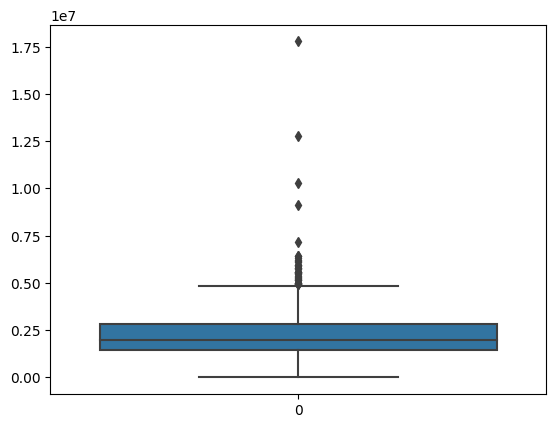

In [81]:
import seaborn as sns
sns.boxplot(rent['보증금평균'])

## 데이터 병합

In [82]:
df = pd.merge(living_popul_year, resident_popul_year)
# df = pd.merge(df, area)
df = pd.merge(df, store_year)
df = pd.merge(df, working_popul_year)
df = pd.merge(df, facilitie_year)
df = pd.merge(df, estimated_sales_year)

In [83]:
# # cols_1 = ['자치구_코드_명', '행정동_코드_명', '임대시세층구분명', '보증금평균', '월임대료평균']
# cols_2 = ['상권_구분_코드_명', '상권_코드_명', '영역_면적', '엑스좌표_값', '와이좌표_값','자치구_코드_명','행정동_코드_명']
# cols_3 = ['총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수',
#           '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
#           '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_06_유동인구_수',
#           '주중_유동인구_수', '주말_유동인구_수']
# cols_4 = ['남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수', '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수', 
#           '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수', '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
#           '총_직장_인구_수']
# cols_5 = ['관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수', '초등학교_수', '중학교_수', '고등학교_수',
#           '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수', '공항_수', '철도_역_수', '버스_터미널_수', '지하철_역_수', '버스_정거장_수']
# cols_6 = ['서비스_업종_코드_명', '점포_수', '유사_업종_점포_수', '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수']
# cols_7 = ['당월_매출_금액', '주중_매출_금액', '주말_매출_금액', 
#           '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~06_매출_금액', 
#           '남성_매출_금액', '여성_매출_금액', 
#           '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', 
#           '당월_매출_건수', '주중_매출_건수', '주말_매출_건수', 
#           '시간대_06~11_매출_건수', '시간대_11~14_매출_건수', '시간대_14~17_매출_건수', '시간대_17~21_매출_건수', '시간대_21~06_매출_건수', 
#           '남성_매출_건수', '여성_매출_건수', 
#           '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수', 
#           '당월_건당_매출_금액', '주중_건당_매출_금액', '주말_건당_매출_금액', 
#           '시간대_06~11_건당_매출_금액', '시간대_11~14_건당_매출_금액', '시간대_14~17_건당_매출_금액', '시간대_17~21_건당_매출_금액', '시간대_21~06_건당_매출_금액', 
#           '남성_건당_매출_금액', '여성_건당_매출_금액', 
#           '연령대_10_건당_매출_금액', '연령대_20_건당_매출_금액', '연령대_30_건당_매출_금액', '연령대_40_건당_매출_금액', '연령대_50_건당_매출_금액', '연령대_60_이상_건당_매출_금액']


# cols = [*cols_2, *cols_3, *cols_4, *cols_5, *cols_6, *cols_7]

# df = df[cols]

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20699 entries, 0 to 20698
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   상권_구분_코드_명        20699 non-null  object 
 1   상권_코드_명           20699 non-null  object 
 2   총_유동인구_수          20699 non-null  float64
 3   남성_유동인구_수         20699 non-null  float64
 4   여성_유동인구_수         20699 non-null  float64
 5   연령대_10_유동인구_수     20699 non-null  float64
 6   연령대_20_유동인구_수     20699 non-null  float64
 7   시간대_06_11_유동인구_수  20699 non-null  float64
 8   시간대_11_14_유동인구_수  20699 non-null  float64
 9   시간대_14_17_유동인구_수  20699 non-null  float64
 10  시간대_17_21_유동인구_수  20699 non-null  float64
 11  시간대_21_06_유동인구_수  20699 non-null  float64
 12  주중_유동인구_수         20699 non-null  float64
 13  주말_유동인구_수         20699 non-null  float64
 14  연령대_30_40_유동인구_수  20699 non-null  float64
 15  연령대_50_60_유동인구_수  20699 non-null  float64
 16  총_상주인구_수          20699 non-null  int64 

In [85]:
df.head()

,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_40_상주인구_수,연령대_50_60_상주인구_수,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,총_직장_인구_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수,당월_개인_매출_금액,당월_법인_매출_금액
0,골목상권,4.19민주묘지역 2번,868030.000,361490.250,506539.250,128381.000,163223.250,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,221593.250,354833.000,1247,596,651,135,121,324,667,한식음식점,23,24,8,2,4,1,1,96,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,1739897842.000,51956.500,1033559973.000,706337869.000,34758423.750,481068145.750,310010178.000,724466602.750,989044375.250,651314594.250,5154289.250,116807695.250,33236.750,18719.750,1961.250,17455.500,10006.500,18257.750,29305.250,21307.250,335.500,5561.500,189594491.750,4275.500,506793356.500,1011603629.250,15916.250,28801.250,1640358969.500,99538872.500
1,골목상권,4.19민주묘지역 2번,868030.000,361490.250,506539.250,128381.000,163223.250,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,221593.250,354833.000,1247,596,651,135,121,324,667,일식음식점,3,3,0,0,0,0,0,96,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,18435727.000,1519.250,15543098.250,2892628.750,0.000,9658447.500,3074001.750,5623422.500,7005386.750,11430340.250,561557.250,6405609.500,1359.250,160.000,0.000,821.500,247.000,441.750,463.250,1056.000,55.250,601.250,79855.250,9.000,6061697.500,5406862.750,495.250,367.500,18435727.000,0.000
2,골목상권,4.19민주묘지역 2번,868030.000,361490.250,506539.250,128381.000,163223.250,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,221593.250,354833.000,1247,596,651,135,121,324,667,패스트푸드점,0,3,0,0,0,0,3,96,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,86378566.500,9085.250,59122514.500,27256052.000,3169532.250,24443206.750,20407827.500,33587803.750,41442797.250,42919979.000,1285185.750,17418838.000,6316.500,2768.750,327.000,2693.500,2068.000,3472.750,4168.750,4881.000,166.250,2228.000,4770196.250,524.000,41815828.750,23842924.000,4243.000,2411.000,84362776.250,2015790.250
3,골목상권,4.19민주묘지역 2번,868030.000,361490.250,506539.250,128381.000,163223.250,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,221593.250,354833.000,1247,596,651,135,121,324,667,치킨전문점,1,3,0,0,0,0,2,96,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,66483629.000,2189.750,43158115.000,23325514.000,52763.750,1660777.000,5881497.500,31315232.250,40050256.500,22819818.250,208308.750,6765486.000,1372.000,817.750,1.250,81.750,189.250,1130.500,1291.500,851.250,11.500,244.000,27573358.500,787.000,24407459.000,31488820.500,835.500,1050.750,62870074.750,3613554.250
4,골목상권,4.19민주묘지역 2번,868030.000,361490.250,506539.250,128381.000,163223.250,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,221593.250,354833.000,1247,596,651,135,121,324,667,분식전문점,2,3,0,0,0,0,1,96,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,116484380.667,11618.333,73379411.667,43104969.000,2948848.333,24056213.667,28566904.667,46828332.333,48130947.000,67577039.667,2272384.000,24387549.667,7502.333,4116.000,175.333,2425.333,3058.333,4640.333,4431.333,7173.6

### 데이터 내보내기

In [86]:
df.to_csv('./data.csv')

## 상관분석

## 다중공선성

In [115]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def backward_elimination(X, y, significance_level=0.05):
    num_features = len(X.columns)
    for i in range(num_features):
        model = sm.OLS(y, X).fit()
        max_p_value = max(model.pvalues)
        if max_p_value > significance_level:
            remove_feature = model.pvalues.idxmax()
            X = X.drop(remove_feature, axis=1)
            print(f"제거된 특성: {remove_feature} (p-값: {max_p_value})")
        else:
            break
    return X

# 데이터를 X (특성) 및 y (타겟)로 분할
X = df.drop('당월_매출_금액', axis=1)
X = X.select_dtypes(include='number')
y = df['당월_매출_금액']

# 절편을 위한 특성 행렬에 상수 항 추가
X = sm.add_constant(X)

# Backward Elimination 수행
X_eliminated = backward_elimination(X, y)

# 최종 모델 피팅
final_model = sm.OLS(y, X_eliminated)

제거된 특성: 주중_매출_건수 (p-값: 0.9999992137095599)
제거된 특성: 연령대_50_60_유동인구_수 (p-값: 0.9999999258338754)
제거된 특성: 시간대_건수~17_매출_건수 (p-값: 0.9999994584660652)
제거된 특성: 버스_터미널_수 (p-값: 0.9999984001065388)
제거된 특성: 종합병원_수 (p-값: 0.9999992783187108)
제거된 특성: 은행_수 (p-값: 0.9999996885674209)
제거된 특성: 여성_매출_건수 (p-값: 0.9999996702192979)
제거된 특성: 시간대_건수~21_매출_건수 (p-값: 0.9999954616794162)
제거된 특성: 시간대_11~14_매출_금액 (p-값: 0.9999987100598512)
제거된 특성: 시간대_06_11_유동인구_수 (p-값: 0.9999991810495581)
제거된 특성: 폐업_점포_수 (p-값: 0.99999780072396)
제거된 특성: 연령대_50_60_매출_건수 (p-값: 0.9999986215771235)
제거된 특성: 총_상주인구_수 (p-값: 0.9999978818345765)
제거된 특성: 지하철_역_수 (p-값: 0.9999992808629954)
제거된 특성: 유사_업종_점포_수 (p-값: 0.9999998878120486)
제거된 특성: 슈퍼마켓_수 (p-값: 0.999999667135782)
제거된 특성: 백화점_수 (p-값: 0.9999995774187065)
제거된 특성: 숙박_시설_수 (p-값: 0.9999970031504775)
제거된 특성: 주중_유동인구_수 (p-값: 0.9999999505123166)
제거된 특성: 버스_정거장_수 (p-값: 0.9999909926198007)
제거된 특성: 폐업_률 (p-값: 0.9999996617713981)
제거된 특성: 연령대_30_40_유동인구_수 (p-값: 0.9999982340725616)
제거된 특성: 연령대_20_상주인구_

In [116]:
X_eliminated

,남성_매출_금액,여성_매출_금액,당월_개인_매출_금액,당월_법인_매출_금액
0,989044375.250,651314594.250,1640358969.500,99538872.500
1,7005386.750,11430340.250,18435727.000,0.000
2,41442797.250,42919979.000,84362776.250,2015790.250
3,40050256.500,22819818.250,62870074.750,3613554.250
4,48130947.000,67577039.667,115707986.667,776394.000
...,...,...,...,...
20694,100861707.333,0.000,100861707.333,10480193.667
20695,276407608.500,371689938.750,648097547.250,9927179.750
20696,59539692.000,64184209.750,123723901.750,7100831.500
20697,230093623.500,290350585.000,520444208.500,766944.250


## 주성분분석

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45572 (\N{HANGUL SYLLABLE NU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools

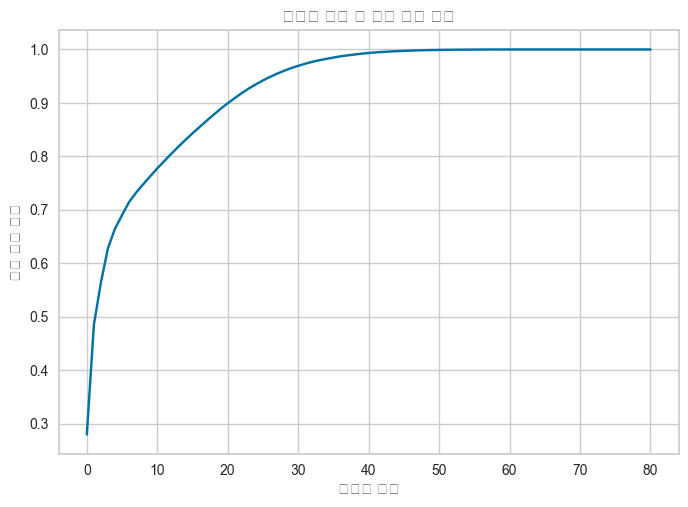

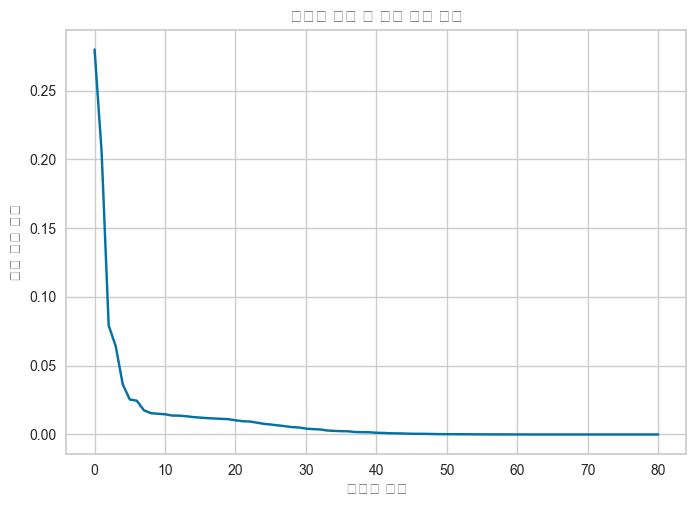

         PC1   PC2    PC3    PC4    PC5
0     -0.024 2.326 -0.175 -0.065  0.839
1     -1.553 2.043  0.051  0.212 -0.533
2     -1.359 2.074 -0.100 -0.074 -0.287
3     -1.482 2.051 -0.032  0.073 -0.354
4     -1.373 2.059 -0.010  0.104 -0.664
...      ...   ...    ...    ...    ...
20694 -2.082 4.396 -0.426  0.306 -0.259
20695 -1.633 4.508 -0.394  0.217 -0.511
20696 -1.918 4.409 -0.442  0.285 -0.548
20697 -1.227 4.608 -0.545 -0.255 -0.546
20698 -1.959 4.414 -0.430  0.289 -0.385

[20699 rows x 5 columns]


In [151]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include='number')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

# PCA 적용
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# 설명된 분산 비율
explained_variance_ratio = pca.explained_variance_ratio_

# 설명된 분산을 그래프로 표시
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산')
plt.title('주성분 개수 대 누적 설명 분산')
plt.show()

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산')
plt.title('주성분 개수 대 누적 설명 분산')
plt.show()

# 원하는 주성분 수 선택 (예: 2)
num_components = 5
selected_components = principal_components[:, :num_components]

# 주성분을 포함한 새로운 DataFrame 생성
pc_df = pd.DataFrame(data=selected_components, columns=[f'PC{i+1}' for i in range(num_components)])

# 주성분을 포함한 결과 DataFrame 표시
print(pc_df)

In [152]:
np.sum(pca.explained_variance_ratio_[:9])

0.74782496518036

## 데이터 모델링

In [153]:
object_columns = df.select_dtypes(include='object')

In [154]:
df_s = pd.concat([object_columns, pc_df], axis = 1)

In [155]:
col_num = list(df.select_dtypes(include = ['number']).columns)

In [156]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[col_num] = scaler.fit_transform(df[col_num])


In [157]:
col_cat = list(df.select_dtypes(include = ['object']).columns)

In [158]:
from sklearn.preprocessing import LabelEncoder
for i in col_cat : 
    le = LabelEncoder()
    le.fit(df_s[i])
    df_s[i] = le.transform(df_s[i])
print(df_s)

         PC1   PC2    PC3    PC4    PC5
0     -0.024 2.326 -0.175 -0.065  0.839
1     -1.553 2.043  0.051  0.212 -0.533
2     -1.359 2.074 -0.100 -0.074 -0.287
3     -1.482 2.051 -0.032  0.073 -0.354
4     -1.373 2.059 -0.010  0.104 -0.664
...      ...   ...    ...    ...    ...
20694 -2.082 4.396 -0.426  0.306 -0.259
20695 -1.633 4.508 -0.394  0.217 -0.511
20696 -1.918 4.409 -0.442  0.285 -0.548
20697 -1.227 4.608 -0.545 -0.255 -0.546
20698 -1.959 4.414 -0.430  0.289 -0.385

[20699 rows x 5 columns]


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

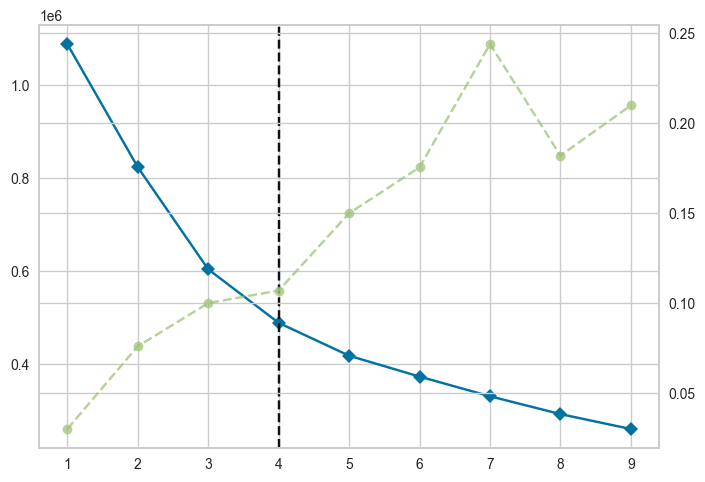

In [159]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df_s)

In [161]:
from sklearn.cluster import KMeans
df_scale = df.copy()
k = 4

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(df)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df_s['cluster'] = model.fit_predict(df_scale)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [162]:
df_s['cluster'].value_counts()

cluster
2    8323
0    6812
1    4520
3    1044
Name: count, dtype: int64

In [165]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 5)
pca_transformed = pca.fit_transform(df_s)
pca_transformed

df_s['pca_x'] = pca_transformed[:, 0]  #x좌표
df_s['pca_y'] = pca_transformed[:, 1]  #y좌표
df_s

,PC1,PC2,PC3,PC4,PC5,cluster,pca_x,pca_y
0,-0.024,2.326,-0.175,-0.065,0.839,0,-0.086,2.385
1,-1.553,2.043,0.051,0.212,-0.533,0,-1.613,2.090
2,-1.359,2.074,-0.100,-0.074,-0.287,0,-1.419,2.123
3,-1.482,2.051,-0.032,0.073,-0.354,0,-1.541,2.098
4,-1.373,2.059,-0.010,0.104,-0.664,0,-1.432,2.107
...,...,...,...,...,...,...,...,...
20694,-2.082,4.396,-0.426,0.306,-0.259,2,-2.070,4.326
20695,-1.633,4.508,-0.394,0.217,-0.511,2,-1.622,4.441
20696,-1.918,4.409,-0.442,0.285,-0.548,2,-1.906,4.339
20697,-1.227,4.608,-0.545,-0.255,-0.546,2,-1.217,4.544


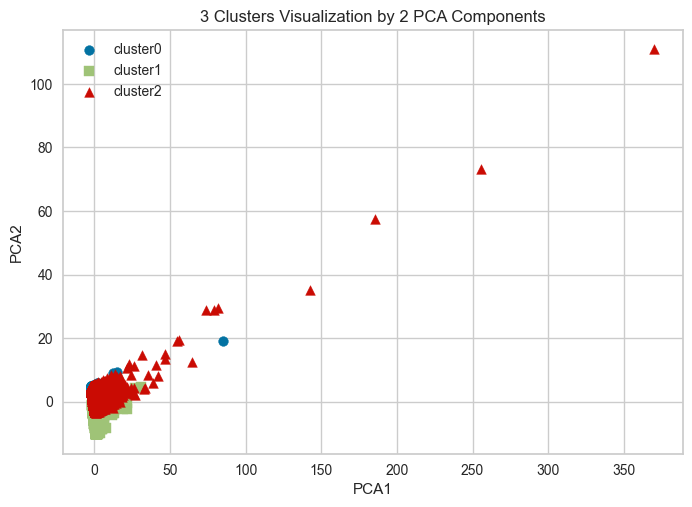

In [166]:
import matplotlib.pyplot as plt

marker0 = df_s[df_s['cluster'] == 0].index
marker1 = df_s[df_s['cluster'] == 1].index
marker2 = df_s[df_s['cluster'] == 2].index
 
 #scatter plot
plt.scatter(x = df_s.loc[marker0, 'pca_x'], y = df_s.loc[marker0, 'pca_y'], marker = 'o')
plt.scatter(x = df_s.loc[marker1, 'pca_x'], y = df_s.loc[marker1, 'pca_y'], marker = 's')
plt.scatter(x = df_s.loc[marker2, 'pca_x'], y = df_s.loc[marker2, 'pca_y'], marker = '^')
 
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.legend(['cluster0', 'cluster1', 'cluster2'])
plt.show()